# Text-Sentiment-Analysis-using-LSTM

In [1]:
!pip install comet-ml torchmetrics --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 698.1/698.1 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.6/969.6 kB 37.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.5 MB/s eta 0:00:00


## 1. Download and Load the dataset

The dataset that the following command will download`IMDb Movie Dataset`.

In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!unzip imdb-dataset-of-50k-movie-reviews.zip

Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
 19% 5.00M/25.7M [00:00<00:00, 34.7MB/s]
100% 25.7M/25.7M [00:00<00:00, 128MB/s] 
Archive:  imdb-dataset-of-50k-movie-reviews.zip
  inflating: IMDB Dataset.csv        


In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv("IMDB Dataset.csv")
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## 2. Data Analysis

train data shape: (40000,)
test data shape: (10000,)


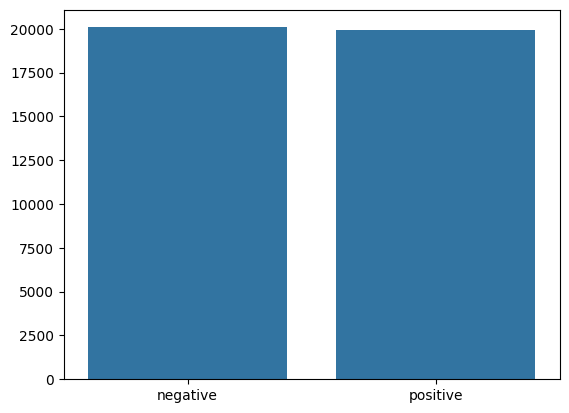

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

X, y = df['review'].values,df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2)
print(f'train data shape: {X_train.shape}')
print(f'test data shape: {X_test.shape}')


val = pd.Series(y_train).value_counts()
sns.barplot(x = np.array(['negative','positive']),
            y = val.values)
plt.show()

## 3. Text Pre-Processing
- Cleaning up the text data by removing punctuation, extra spaces, and numbers.
- Transform sentences into individual words, remove common words (known as "stop words") and then lemmatize remaining words for its repsective root words.
- Keeping track of the 1000 most frequently used words in the dataset
- Assigning tracked words a unique identifier, forming dictionary for one-hot encoding
- Ensuring all sequences have the same length by padding or truncating them as needed by 1000+1 tokens. (+1 for padding)

In [5]:
import re
import nltk
from collections import Counter
from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Precompile regular expressions for faster preprocessing
non_word_chars_pattern = re.compile(r"[^\w\s]")
whitespace_pattern = re.compile(r"\s+")
url_pattern = re.compile(r'http\S+|www\S+')
username_pattern = re.compile(r"@([^\s]+)")
hashtags_pattern = re.compile(r"#\d+")
br_pattern = re.compile(r'<br\s*/?>\s*<br\s*/?>')
contractions_pattern = re.compile(r"\b(can't|won't|n't|'re|'s|'d|'ll|'t|'ve|'m)\b")

# Load stopwords once
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Expand common contractions
contractions_dict = {
    "can't": "cannot", "won't": "will not", "n't": "not", "'re": "are", "'s": "is",
    "'d": "would", "'ll": "will", "'t": "not", "'ve": "have", "'m": "am"
}

def expand_contractions(text):
    return contractions_pattern.sub(lambda x: contractions_dict.get(x.group()), text)

def preprocess_string(s):
    # Lowercase text
    s = s.lower()
    # Expand contractions
    s = expand_contractions(s)
    # Remove URLs
    s = url_pattern.sub('', s)
    # Remove usernames and hashtags
    s = username_pattern.sub('', s)
    s = hashtags_pattern.sub('', s)
    # Remove <br /> HTML tags
    s = br_pattern.sub('', s)
    # Remove non-word characters (preserving letters and numbers only)
    s = non_word_chars_pattern.sub(' ', s)
    # Replace multiple spaces with a single space
    s = whitespace_pattern.sub(' ', s)

    # Tokenize, remove stopwords, and lemmatize
    tokens = s.split()
    filtered_tokens = [
        lemmatizer.lemmatize(word) for word in tokens if word not in stop_words
    ]
    return ' '.join(filtered_tokens)

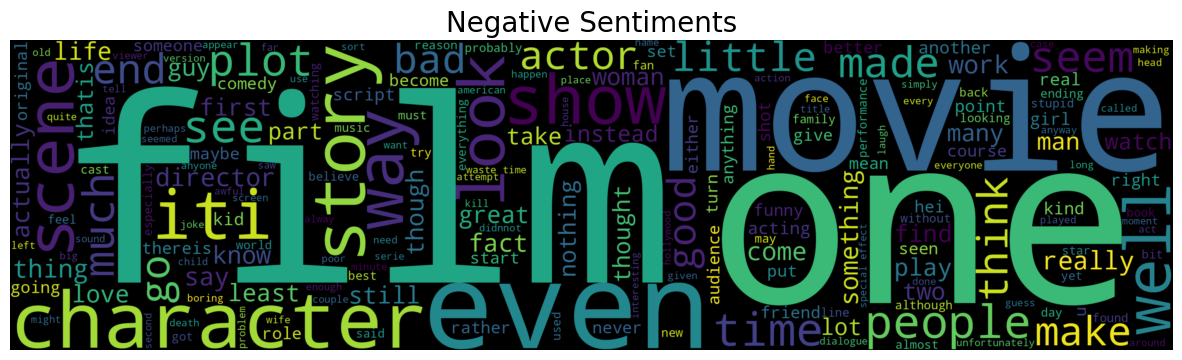

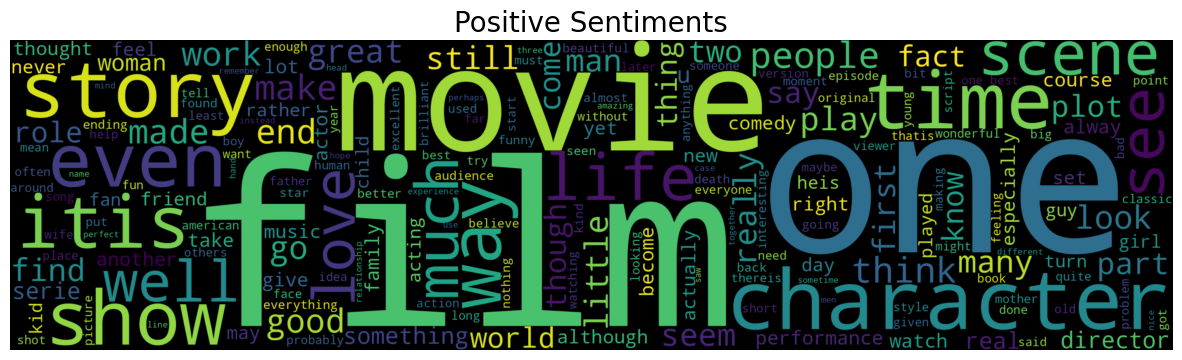

In [7]:
from wordcloud import WordCloud, STOPWORDS

# Apply preprocessing to the dataset
df['cleaned_text'] = df['review'].apply(preprocess_string)

# Separate by sentiment
negative_df = df[df['sentiment'] == 'negative']
positive_df = df[df['sentiment'] == 'positive']

# Function to generate and display WordCloud
def generate_wordcloud(data, title):
    words = ' '.join(data['cleaned_text'])
    wordcloud = WordCloud(
        stopwords=STOPWORDS,
        background_color='black',
        width=3000,
        height=800
    ).generate(words)

    plt.figure(figsize=(15, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

# Generate WordClouds
generate_wordcloud(negative_df, 'Negative Sentiments')
generate_wordcloud(positive_df, 'Positive Sentiments')

In [8]:
def tokenize(X_train, y_train, X_val, y_val, seq_len):
    word_list = []

    for sent in tqdm(X_train, desc="Preprocessing train data"):
        words = [preprocess_string(word) for word in sent.lower().split()]
        word_list.extend([word for word in words if word not in stop_words and word != ''])

    corpus = Counter(word_list)
    # Sorting on the basis of most common words
    corpus_ = sorted(corpus, key=corpus.get, reverse=True)[:seq_len]
    # Creating a dictionary
    onehot_dict = {w: i + 1 for i, w in enumerate(corpus_)}

    # Tokenize and pad sequences
    final_list_train = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                        for sent in tqdm(X_train, desc="Tokenizing and padding train data")]
    final_list_train = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                        for padded_tokens in final_list_train]

    final_list_test = [[onehot_dict.get(preprocess_string(word), 0) for word in sent.lower().split() if preprocess_string(word) in onehot_dict]
                       for sent in tqdm(X_val, desc="Tokenizing and padding validation data")]
    final_list_test = [padded_tokens[-seq_len:] if len(padded_tokens) > seq_len
                       else [0] * (seq_len - len(padded_tokens)) + padded_tokens
                       for padded_tokens in final_list_test]

    encoded_train = np.array([1 if label == 'positive' else 0 for label in y_train])
    encoded_test = np.array([1 if label == 'positive' else 0 for label in y_val])

    return np.array(final_list_train), encoded_train, np.array(final_list_test), encoded_test, onehot_dict

In [9]:
seq_len = 1000
X_train, y_train, X_test, y_test, vocab = tokenize(X_train,
                                                   y_train,
                                                   X_test,
                                                   y_test,
                                                   seq_len)

len(X_train), len(X_test)

Tokenizing and padding validation data: 100%|██████████| 10000/10000 [00:17<00:00, 556.35it/s]


(40000, 10000)

In [10]:
import pickle

# Save the corpus dictionary
with open("vocab.pkl", 'wb') as f:
    pickle.dump(vocab, f)

In [11]:
X_train, y_train

(array([[  0,   0,   0, ..., 248, 709, 116],
        [  0,   0,   0, ..., 412, 154, 215],
        [  0,   0,   0, ...,  26, 298, 446],
        ...,
        [  0,   0,   0, ...,  43,   2,   8],
        [  0,   0,   0, ..., 560, 513, 332],
        [  0,   0,   0, ...,   1,  61, 204]]),
 array([1, 1, 0, ..., 0, 1, 1]))

## 4. Preparing the data using DataLoader

In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

In [13]:
# Create Tensor datasets
train_data = TensorDataset(torch.from_numpy(X_train),
                           torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_test),
                           torch.from_numpy(y_test))

BATCH_SIZE = 128

# Create train and valid dataloader
train_dataloader = DataLoader(train_data,
                              shuffle=True,
                              batch_size=BATCH_SIZE)
valid_dataloader = DataLoader(valid_data,
                              shuffle=False,
                              batch_size=BATCH_SIZE)

len(train_dataloader), len(valid_dataloader)

(313, 79)

In [14]:
# Sampling one bacth from train_dataloader
sample_data = iter(train_dataloader)
sample_x, sample_y = next(sample_data)

print('Sample input size:', sample_x.size())     # batch_size, seq_length
print('Sample input:', sample_x)
print('Sample output:', sample_y)

Sample input size: torch.Size([128, 1000])
Sample input: tensor([[  0,   0,   0,  ...,  17,   1, 451],
        [  0,   0,   0,  ...,   7,  15, 207],
        [  0,   0,   0,  ..., 768, 141, 270],
        ...,
        [  0,   0,   0,  ...,   3,  26,  60],
        [  0,   0,   0,  ..., 122, 507, 686],
        [  0,   0,   0,  ..., 458,  15,   3]])
Sample output: tensor([1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
        0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
        0, 1, 1, 0, 1, 1, 0, 0])


## 5. Building a LSTM Model

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [16]:
class AdditiveAttention(nn.Module):
    def __init__(self, query_dim, key_dim, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.query_layer = nn.Linear(query_dim, hidden_dim)
        self.key_layer = nn.Linear(key_dim, hidden_dim)
        self.energy_layer = nn.Linear(hidden_dim, 1)

    def forward(self, query, keys, values):
        query = self.query_layer(query).unsqueeze(1)
        keys = self.key_layer(keys)

        # Compute energy scores
        energy = torch.tanh(query + keys)
        attention_scores = self.energy_layer(energy).squeeze(-1)
        attention_weights = F.softmax(attention_scores, dim=-1)

        # Compute context vector
        context = torch.bmm(attention_weights.unsqueeze(1), values).squeeze(1)

        return context, attention_weights

In [17]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim=1, num_layers=1, bidirectional=False, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # Embedding layer
        self.embedding = nn.Embedding(input_dim, embedding_dim)

        # LSTM layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers,
                            bidirectional=bidirectional,
                            batch_first=True,
                            dropout=dropout)

        # Attention layer
        attention_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.attention = AdditiveAttention(query_dim=attention_dim,
                                           key_dim=attention_dim,
                                           hidden_dim=hidden_dim)

        # Output layer
        self.fc = nn.Linear(attention_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through embedding layer
        x = self.embedding(x)

        # Pass through LSTM layer
        lstm_out, (hn, _) = self.lstm(x)  # lstm_out: (batch_size, seq_len, hidden_dim * num_directions)

        # Set query as the last hidden state of the LSTM
        if self.bidirectional:
            # Concatenate the last states of the two directions
            query = torch.cat((hn[-2], hn[-1]), dim=1)
        else:
            # Use the last hidden state for unidirectional LSTM
            query = hn[-1]

        # Compute attention
        context, attention_weights = self.attention(query, lstm_out, lstm_out)

        # Output layer with sigmoid activation
        out = self.fc(context)
        out = self.sigmoid(out).squeeze(1)  # Squeeze to remove unnecessary dimensions for binary classification
        return out, attention_weights

In [ ]:
model = LSTMModel(input_dim=len(vocab) + 1,   # 1 extra for padding
                  embedding_dim=64,
                  hidden_dim=256,
                  output_dim=1,
                  num_layers=2,
                  bidirectional=True,         # True for bidirectional LSTM else False for unidirectional LSTM
                  dropout=.2)

# Pass model to device 'cuda' if selected
model.to(device)

LSTMModel(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): AdditiveAttention(
    (query_layer): Linear(in_features=512, out_features=256, bias=True)
    (key_layer): Linear(in_features=512, out_features=256, bias=True)
    (energy_layer): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 6. Create Train and Validation Loop Function

In [19]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="binary").to(device)

In [20]:
def train_step(model, data_loader, loss_fn, optimizer, clip, device, epoch, experiment):
    train_loss, train_acc = 0, 0
    train_losses, train_accuracies = [], []

    model.train()

    for _, (inputs, labels) in enumerate(data_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        output, _ = model(inputs)

        loss = loss_fn(output, labels.float())
        train_loss += loss

        preds = torch.round(output.squeeze())
        train_acc += torchmetrics_accuracy(preds, labels)

        optimizer.zero_grad()
        loss.backward()
        clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)

    # Log metrics to a dictionary
    metrics_dict = {
        "train_loss": train_loss,
        "train_accuracy": train_acc,
    }

    # Log metrics dictionary to Comet ML
    experiment.log_metrics(metrics_dict, step=epoch)

    train_losses.append(train_loss.item())
    train_accuracies.append(train_acc.item())

    return train_losses, train_accuracies


def test_step(model, data_loader, loss_fn, device, epoch, experiment):
    test_loss, test_acc = 0, 0
    test_losses, test_accuracies = [], []
    preds_list, labels_list = [], []

    model.eval()

    with torch.inference_mode():
        for _, (inputs, labels) in enumerate(data_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            output, _ = model(inputs)

            loss = loss_fn(output, labels.float())
            test_loss += loss

            preds = torch.round(output.squeeze())
            test_acc += torchmetrics_accuracy(preds, labels)

            # Collect predictions and labels for confusion matrix
            preds_list.extend(preds.cpu().long().numpy())
            labels_list.extend(labels.cpu().long().numpy())

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        # Log metrics to a dictionary
        metrics_dict = {
            "test_loss": test_loss,
            "test_accuracy": test_acc,
        }

        # Log metrics dictionary to Comet ML
        experiment.log_metrics(metrics_dict, step=epoch)

        test_losses.append(test_loss.item())
        test_accuracies.append(test_acc.item())

        return test_losses, test_accuracies, preds_list, labels_list

In [21]:
def train(model, train_dataloader, test_dataloader, classes, loss_fn, optimizer, clip, epochs, device, experiment):
    results = {"train_losses_history": [],
               "train_accuracies_history": [],
               "test_losses_history": [],
               "test_accuracies_history": []

    }
    test_acc_min = 0

    for epoch in tqdm(range(1, epochs+1)):
        train_losses, train_accuracies = train_step(model,
                                                    train_dataloader,
                                                    loss_fn, optimizer, clip,
                                                    device,
                                                    epoch,
                                                    experiment)
        test_losses, test_accuracies, preds_list, labels_list = test_step(model,
                                                                          test_dataloader,
                                                                          loss_fn,
                                                                          device,
                                                                          epoch,
                                                                          experiment)

        # Calculate avg. loss and accuracy
        avg_train_loss = sum(train_losses) / len(train_losses)
        avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
        avg_test_loss = sum(test_losses) / len(test_losses)
        avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

        print(f'\nTrain loss: {avg_train_loss:.4f} ---- Train acc: {avg_train_accuracy:.4f}')
        print(f'Test loss: {avg_test_loss:.4f} ---- Test acc: {avg_test_accuracy:.4f}\n')

        # Save model if avg_test_accuracy is higher
        if avg_test_accuracy > test_acc_min:
            torch.save(model.state_dict(), 'best_model.pth')
            test_acc_min = avg_test_accuracy
            print(f"Saved best model at epoch: {epoch}\n")

            # Log the confusion matrix to Comet
            experiment.log_confusion_matrix(
                y_true=np.array(labels_list),
                y_predicted=np.array(preds_list),
                labels=classes,
            )

        results["train_losses_history"].append(avg_train_loss)
        results["train_accuracies_history"].append(avg_train_accuracy)
        results["test_losses_history"].append(avg_test_loss)
        results["test_accuracies_history"].append(avg_test_accuracy)

    return results

## 7. Train and Evaluate the Model

In [22]:
# Loss function and Optimizer
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=3e-4)

In [23]:
import comet_ml

comet_ml.login(project_name="tweet-sentiment-analysis")
exp = comet_ml.Experiment()

Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/luluw8071/tweet-sentiment-analysis/f3c2ef27c8fd4a56b83880172c2081c4



In [24]:
results = train(model = model,
                train_dataloader = train_dataloader,
                test_dataloader = valid_dataloader,
                classes = ["negative", "positive"],
                loss_fn = loss_fn,
                optimizer = optimizer,
                epochs = 10,
                clip = 5,
                device = device,
                experiment = exp)

 10%|█         | 1/10 [01:11<10:41, 71.33s/it]


Train loss: 0.6030 ---- Train acc: 0.6362
Test loss: 0.4613 ---- Test acc: 0.7837

Saved best model at epoch: 1



 20%|██        | 2/10 [02:22<09:29, 71.21s/it]


Train loss: 0.4116 ---- Train acc: 0.8120
Test loss: 0.3725 ---- Test acc: 0.8345

Saved best model at epoch: 2



 30%|███       | 3/10 [03:34<08:22, 71.81s/it]


Train loss: 0.3513 ---- Train acc: 0.8448
Test loss: 0.3486 ---- Test acc: 0.8507

Saved best model at epoch: 3



 40%|████      | 4/10 [04:48<07:14, 72.44s/it]


Train loss: 0.3228 ---- Train acc: 0.8594
Test loss: 0.3344 ---- Test acc: 0.8563

Saved best model at epoch: 4



 50%|█████     | 5/10 [06:02<06:04, 72.95s/it]


Train loss: 0.3028 ---- Train acc: 0.8711
Test loss: 0.3332 ---- Test acc: 0.8561



 60%|██████    | 6/10 [07:16<04:53, 73.25s/it]


Train loss: 0.2860 ---- Train acc: 0.8795
Test loss: 0.3349 ---- Test acc: 0.8624

Saved best model at epoch: 6



 70%|███████   | 7/10 [08:29<03:40, 73.43s/it]


Train loss: 0.2730 ---- Train acc: 0.8847
Test loss: 0.3365 ---- Test acc: 0.8585



 80%|████████  | 8/10 [09:43<02:27, 73.60s/it]


Train loss: 0.2545 ---- Train acc: 0.8945
Test loss: 0.3340 ---- Test acc: 0.8588



 90%|█████████ | 9/10 [10:57<01:13, 73.68s/it]


Train loss: 0.2401 ---- Train acc: 0.9004
Test loss: 0.3590 ---- Test acc: 0.8542



100%|██████████| 10/10 [12:11<00:00, 73.16s/it]


Train loss: 0.2214 ---- Train acc: 0.9096
Test loss: 0.3344 ---- Test acc: 0.8618



In [25]:
exp.log_model(
    name="Binary_Sentiment_BiLSTM_Attention_1000",
    file_or_folder="best_model.pth"
)

exp.log_model(
    name="Vocab",
    file_or_folder="vocab.pkl"
)

exp.end()

COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : fancy_cuckoo_5831
COMET INFO:     url                   : https://www.comet.com/luluw8071/tweet-sentiment-analysis/f3c2ef27c8fd4a56b83880172c2081c4
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     test_accuracy [10]  : (0.7837223410606384, 0.8624407052993774)
COMET INFO:     test_loss [10]      : (0.333232045173645, 0.46126165986061096)
COMET INFO:     train_accuracy [10] : (0.6361820697784424, 0.9095696806907654)
COMET INFO:     train_loss [10]     : (0.22141794860363007, 0.6030354499816895)
COMET INFO:   Others:
COMET INFO

## 8. Plot Loss and Accuracy Curves

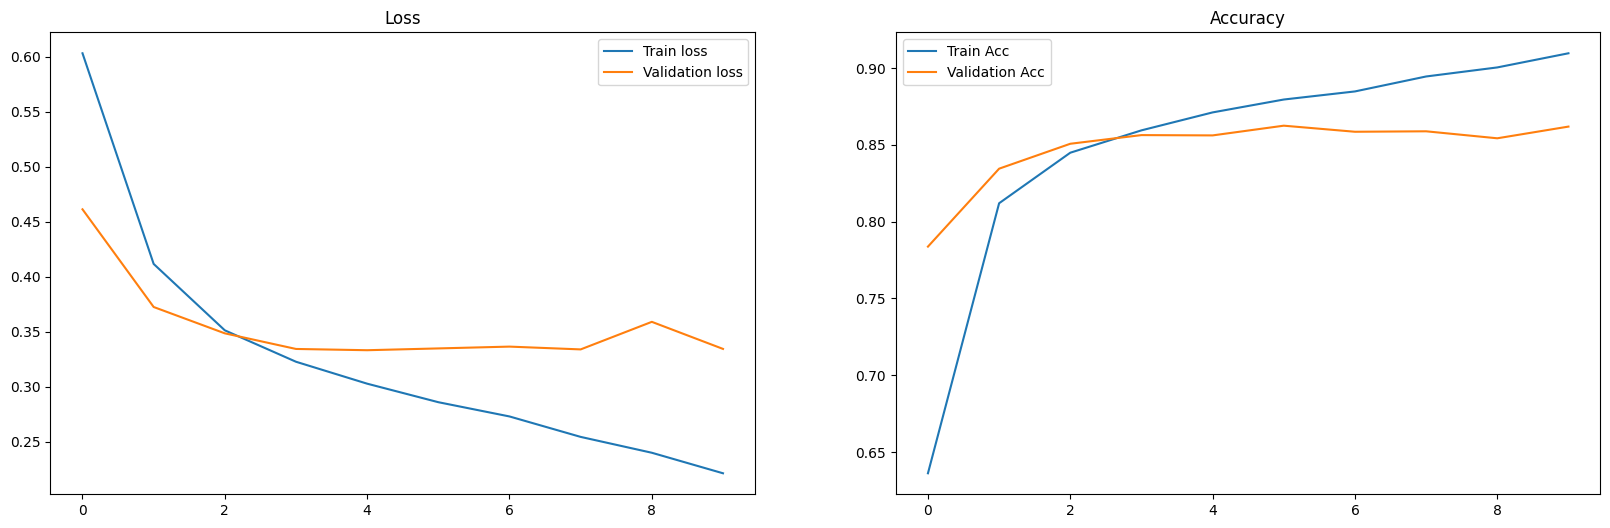

In [26]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(results["train_losses_history"], label='Train loss')
plt.plot(results["test_losses_history"], label='Validation loss')
plt.title("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(results["train_accuracies_history"], label='Train Acc')
plt.plot(results["test_accuracies_history"], label='Validation Acc')
plt.title("Accuracy")
plt.legend()

plt.show()

## 9. Load Model to `cpu`

In [27]:
# Load model configs
model = LSTMModel(input_dim=len(vocab) + 1,
                  embedding_dim=64,
                  hidden_dim=256,
                  output_dim=1,
                  num_layers=2,
                  bidirectional=True,
                  dropout=.2)

# Load the model state dict
model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Move the model to CPU
model.to('cpu')

<ipython-input-27-ffa15416625c>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth", map_location=device))


LSTMModel(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (attention): AdditiveAttention(
    (query_layer): Linear(in_features=512, out_features=256, bias=True)
    (key_layer): Linear(in_features=512, out_features=256, bias=True)
    (energy_layer): Linear(in_features=256, out_features=1, bias=True)
  )
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

## 10. Make Prediction using Loaded Model

In [28]:
# Load vocab pkl
with open("vocab.pkl", 'rb') as f:
    vocab = pickle.load(f)

In [29]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

def predict_text(text):
    word_seq = np.array([vocab[preprocess_string(word)] for word in text.split()
                      if preprocess_string(word) in vocab.keys()])
    word_seq = np.expand_dims(word_seq,axis=0)
    pad =  torch.from_numpy(padding_(word_seq, 1000))
    inputs = pad.to('cpu')
    output, _ = model(inputs)
    return torch.round(output.squeeze()), output.item()

In [30]:
import random

# Randomly select 15 index from dataset to predict
for _ in range(15):
    index = random.randint(0, len(df) - 1)
    review = df['review'][index]
    actual_sentiment = df['sentiment'][index]

    print(review)
    # print(f'Actual sentiment: {actual_sentiment}')

    # Prediction with debug output
    preds, prob = predict_text(review)
    predicted_label_text = "positive" if preds == 1.0 else "negative"
    prob = prob if preds == 1.0 else 1 - prob

    # Color-coding output based on prediction matching actual sentiment
    color = '\033[92m' if actual_sentiment == predicted_label_text else '\033[91m'
    print(f'Predicted sentiment: {color}{predicted_label_text}\033[0m with confidence rate: {prob*100:3f}%')
    print('=' * 70)

We showed this movie at the local Film Society, and the art-house crowd had the time of their cinematic lives. It's tasteless, groovy and very funny in a sixties kind of way. The Kraft Kitchen recipe sketch had them laughing like maniacs. The rest is a mixed bag, but the highs definitely beat the lows. By the way, whatever happened to Ken Shapiro??
Predicted sentiment: positive with confidence rate: 71.963799%
Even with only 6,000 bucks and a cast of part-time actors, Christopher Nolan was a master. Nolan is in my opinion, the next great and our first taste of Nolan doesn't contradict that.<br /><br />None of the problems that constantly plaque and discredit the low budget independent picture haunt Nolan and crew. Our actors are inexperienced and young but they deliver and engage us in this story. In all honesty I think Following is Nolan's best screenplay because it is the one he had the most control over. It's a beautifully imagined film. It takes us into a world where we don't feel 

In [31]:
def predict_custom_text(custom_text):
    preds, prob = predict_text(custom_text)
    label = "positive" if preds == 1.0 else "negative"
    prob = prob if preds == 1.0 else 1 - prob
    print(f'Predicted: {label} \nProbability {prob*100 :.3f}%')

In [32]:
# Custom Negative Text
custom_text = """
I recently purchased this phone and it has been nothing but a disappointment.
The battery drains incredibly fast, even when it's not in use.
The screen flickers and sometimes goes completely black, forcing me to restart it.
The camera quality is horrible, with blurry photos and grainy videos, even in good lighting.
The device also heats up quickly when using simple apps like the browser or social media.
I contacted customer support, but their response was slow and unhelpful.
It's frustrating to spend so much money on a product that doesn't work as advertised. I would definitely not recommend this phone to anyone.
"""
predict_custom_text(custom_text)

Predicted: negative 
Probability 94.655%


In [33]:
# Custom Positive Text
custom_text = """
I absolutely love this new laptop! It has exceeded all my expectations in terms of speed and performance. The processor is incredibly fast, and I can switch between multiple applications without any lag. The display is crystal clear, and the colors are vibrant, making it perfect for both work and entertainment. The keyboard feels smooth to type on, and the trackpad is highly responsive.
The battery life is also impressive, lasting a full day with moderate use.
I was a bit hesitant at first, but after using it for a few weeks, I can confidently say it's the best laptop I've owned in years.
Highly recommend!
"""
predict_custom_text(custom_text)

Predicted: positive 
Probability 99.214%


In [34]:
# Custom Positive Text
custom_text = """
I absolutely love this new laptop!
"""
predict_custom_text(custom_text)

Predicted: positive 
Probability 94.481%


### Fail Case Scenario

If text length is too small, it fails to predict the sentiment. This might be due to
- poor quality embeddings and data
- simple sequential model

In [46]:
custom_text = """
I absolutely hated the product. Never buy it.
"""
predict_custom_text(custom_text)

Predicted: positive 
Probability 95.045%


In [43]:
custom_text = """
I absolutely hated the product. NEver buy it. The motherboard has some issues so donot waste money on this product.
"""
predict_custom_text(custom_text)

Predicted: negative 
Probability 95.967%


In [44]:
custom_text = """
I absolutely hated the product. NEver buy it. The motherboard has some issues so donot waste money on this product.
Even the service is bad.
"""
predict_custom_text(custom_text)

Predicted: negative 
Probability 96.448%
